## Request NOAA Daily Meterology Data.
This notebook is an example of how to use pydrology to download and resample NOAA SC-ACIS. NOAA provides daily meteorology data, which can be accessed on their website (https://scacis.rcc-acis.org/). The data requests in this notebook come from Single Station Products > Daily Data Listing. The data comes from a network of weather monitoring stations that may have different meterology options, most often temperature and precipitation. Weather stations may have different time periods of data due to when they were put online or taken off. If your request contains a longer time period than is available, no-data values will be used as placeholders for the missing data.  

The general workflow for requesting USGS streamflow data is as follows:
1. Request the MET data for a particular site using the function call below.
2. Inspect the raw data for missing values and other issues.
3. Handle any data cleaning and then the data is ready for use!
4. (Optional) Downsample or upsample the data using the provided functions.

In [1]:
# Library imports.
import numpy as np
import matplotlib.pyplot as plt

# Local imports.
from pydrology.data_requests import request_acis_data
from pydrology import plotting
from pydrology import time_series

## 1) Request meteorology data.

In [11]:
# Site ID to request data for.
# Add <space>6 to the end of GHCN site IDs. Add <space>2 for coop site ids. (E.g., "USS0020A23S" => "USS0020A23S 6")
site_id = '304174 2'  # Ithaca.

# list of met elements to request.
# Options in dictionary below:
met_elements_ref = {'maxt': 'MaxTemp', 'mint': 'MinTemp', 'avgt': 'AvgTemp', 'pcpn': 'Precipitation',
                 'snow': 'SnowDepth'}
met_elements = ['maxt', 'mint', 'snow', 'avgt', 'pcpn']

# Date range.
start_date = '2022-01-01'  # YYYY-mm-dd.
end_date = '2022-03-22'


## Make the request.
acis_df = request_acis_data(met_elements, site_id, start_date, end_date)

## 2) Inspect the data.

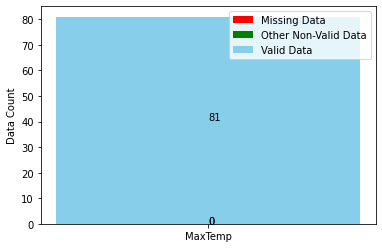

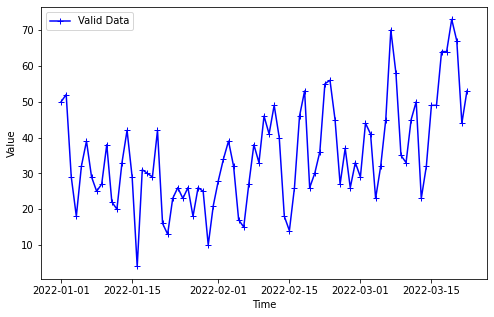

In [12]:
# Plotting column names and missing value.
data_column_name = 'MaxTemp'
time_column_name = 'Date'
missing_value = 'M'

# Plot the valid, missing, and non-valid data as a bar chart.
plotting.plot_missing_ratio(acis_df, data_column_name)

# Plot the data as a time series.
plotting.plot_data_timeseries(acis_df, data_column_name, time_column_name, missing_value=missing_value)

## 3) Data cleaning.

In [13]:
dt = 1440 # Time step in minutes.
data_columns = ['MaxTemp', 'MinTemp', 'SnowDepth', 'AvgTemp', 'Precipitation']
time_column = 'Date'

### Set Trace to Zero. 'T' => 0.0

In [14]:
# Trace means that there was precipitation, but it was below the measurement threshold.
trace_value = 'T'
acis_df.replace(trace_value, 0.0, inplace=True)

### Set Missing to NaN. 'M' => NaN

In [15]:
missing_value = 'M'
acis_df.replace(missing_value, np.nan, inplace=True)

### Add NaN values to missing time steps.

In [16]:
acis_df = time_series.standardize_datetime(acis_df, time_column, data_columns, dt)

### Interpolation of NaN values.

In [17]:
acis_df = time_series.interpolate_time_series(acis_df, data_columns, method='linear')

## 4) Data resampling.

In [18]:
new_dt = 360 # New time step in minutes. 
resample_acis_df = time_series.resample_data(acis_df, time_column, data_columns, new_dt)
resample_acis_df.head()

,site_id,name,latitude,longitude,MaxTemp,MinTemp,SnowDepth,AvgTemp,Precipitation,Date
0,304174-2,ITHACA CORNELL UNIV,42.44915,-76.44905,50.0,34.00,0.0,42.000,0.020,2022-01-01 00:00:00
1,304174-2,ITHACA CORNELL UNIV,42.44915,-76.44905,50.5,32.75,0.0,41.625,0.085,2022-01-01 06:00:00
2,304174-2,ITHACA CORNELL UNIV,42.44915,-76.44905,51.0,31.50,0.0,41.250,0.150,2022-01-01 12:00:00
3,304174-2,ITHACA CORNELL UNIV,42.44915,-76.44905,51.5,30.25,0.0,40.875,0.215,2022-01-01 18:00:00
4,304174-2,ITHACA CORNELL UNIV,42.44915,-76.44905,52.0,29.00,0.0,40.500,0.280,2022-01-02 00:00:00


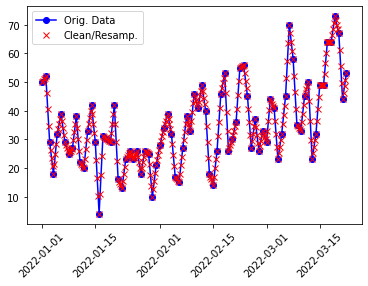

In [19]:
fig, ax = plt.subplots()
ax.plot(acis_df[time_column], acis_df['MaxTemp'], 'b-o', label='Orig. Data')
ax.plot(resample_acis_df[time_column], resample_acis_df['MaxTemp'], 'rx', label='Clean/Resamp.')
ax.legend()
ax.tick_params(axis='x', rotation=45)
plt.show()

## 5) Save Data Frame.

In [ ]:
acis_df.to_csv('PATH.csv', index=False)